In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
#from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import bayesian_search_forecaster
#from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler



1. Data Preprocessing:
Load the datasets


In [2]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")
percapita_labor = pd.read_csv("Resources/female-labor-force-participation-rates-by-national-per-capita-income.csv")
school_years = pd.read_csv("Resources/mean-years-of-schooling-female.csv")
maternity_leave = pd.read_csv("Resources/paid-leave-at-least-14-weeks-mothers.csv")
labor_sector = pd.read_csv("Resources/share-of-female-workers-by-sector.csv")


In [3]:
# View the Columns and Rows for each of the dataset 
print(f'Shape of average_hours DataFrame: {average_hours.shape}')
print(f'Shape of employment_ratio DataFrame: {employment_ratio.shape}')
print(f'Shape of wage_gap DataFrame: {wage_gap.shape}')
print(f'Shape of percapita_labor DataFrame: {percapita_labor.shape}')
print(f'Shape of school_years DataFrame: {school_years.shape}')
print(f'Shape of maternity_leave DataFrame: {maternity_leave.shape}')
print(f'Shape of labor_sector DataFrame: {labor_sector.shape}')

Shape of average_hours DataFrame: (971, 4)
Shape of employment_ratio DataFrame: (3919, 4)
Shape of wage_gap DataFrame: (636, 4)
Shape of percapita_labor DataFrame: (7185, 6)
Shape of school_years DataFrame: (1502, 4)
Shape of maternity_leave DataFrame: (10206, 4)
Shape of labor_sector DataFrame: (2781, 6)


In [4]:
# Rename Columns to make it shorter
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
percapita_labor = percapita_labor.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)': 'Labor_Force'})
school_years = school_years.rename(columns={'Mean years of schooling (ISCED 1 or higher), population 25+ years, female': 'School_Years_Mean'})
maternity_leave = maternity_leave.rename(columns={'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'Paid_Leave'})
labor_sector = labor_sector.rename(columns={'Female share of employment in agriculture (%)': 'Argiculture','Female share of employment in industry (%)': 'Industry','Female share of employment in services (%)': 'Services'})


In [5]:
# Drop Null Values from these two datasets 
average_hours.dropna(inplace=True)
employment_ratio.dropna(inplace=True)


In [6]:
# Merge the datasets
merged_df= average_hours.merge(employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(wage_gap, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(percapita_labor, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(school_years, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(maternity_leave, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(labor_sector, on=['Entity', 'Code', 'Year'], how='outer')

# Check the result
print(merged_df.shape)


(11400, 14)


In [7]:
# Check for null values 
print(merged_df.isnull().sum())

Entity                                                     0
Code                                                     458
Year                                                       0
Avg_Hours_Worked                                       10512
Emp_Pop_Ratio                                           7716
Gender_Wage_Gap                                        10764
Labor_Force                                             4969
GDP per capita, PPP (constant 2017 international $)     4838
Continent                                              11115
School_Years_Mean                                       9898
Paid_Leave                                              1194
Argiculture                                             8675
Industry                                                8653
Services                                                8655
dtype: int64


In [8]:
#Drop colum "Continent"
merged_df = merged_df.drop("Continent", axis=1)

In [9]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [10]:
# Filter rows with less than <= 3 letters
filtered_df = merged_df[merged_df['Code'].str.len()<=3]


In [11]:
# Check the data types of each column
print(filtered_df.dtypes)


Entity                                                  object
Code                                                    object
Year                                                     int64
Avg_Hours_Worked                                       float64
Emp_Pop_Ratio                                          float64
Gender_Wage_Gap                                        float64
Labor_Force                                            float64
GDP per capita, PPP (constant 2017 international $)    float64
School_Years_Mean                                      float64
Paid_Leave                                             float64
Argiculture                                            float64
Industry                                               float64
Services                                               float64
dtype: object


In [12]:
# Perform some basic EDA- View the dataset's distribution
print(filtered_df.describe())


               Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap  \
count  10778.000000        888.000000    3662.000000       636.000000   
mean    1997.015866         35.485752      44.861098        19.385535   
std       15.581715          4.047832      14.312533        10.053530   
min     1960.000000         24.038079       2.500000         0.000000   
25%     1984.000000         32.523503      36.909500        13.200000   
50%     1997.000000         35.616393      46.108000        17.900000   
75%     2011.000000         38.548941      53.131750        23.400000   
max     2023.000000         44.813507      94.500000        52.800000   

       Labor_Force  GDP per capita, PPP (constant 2017 international $)  \
count  5951.000000                                        6085.000000     
mean     49.674714                                       18408.744201     
std      15.605830                                       20667.723060     
min       4.948000                        

Handle Null Values using the KNNImputer. For KNNImputer can only work on numerical columns. 
First step is to define numerical and catrgorical columns and then train only on the numerical columns. 

In [13]:
# Define numerical and catrgorical columns 
numerical_cols = ['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

categorical_cols = ['Entity', 'Code']

In [14]:
# Train on the numerical columns with n_neighbor =5
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Impute null values in numerical columns using KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# One-Hot Encode categorical columns
#ohe = OneHotEncoder(handle_unknown='ignore')
#encoded_array = ohe.fit_transform(filtered_df[categorical_cols])
#encoded_df = pd.DataFrame(encoded_array.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

# Concatenate imputed numerical columns with one-hot encoded categorical columns
#df_encoded = pd.concat([pd.DataFrame(imputed_num_data, columns=numerical_cols), encoded_df], axis=1)


In [15]:
# Check for null values before imputation
print("Null values before imputation:")
print(filtered_df[numerical_cols].isnull().sum())

#imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# Check null values after the imputation 
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_num_df.reset_index(inplace=True, drop=True)
cat_df= filtered_df[categorical_cols]
cat_df.reset_index(inplace=True, drop=True)

print(cat_df.isnull().sum())
print("Null values after imputation:")
print(imputed_num_df.isnull().sum())

Null values before imputation:
Year                                                       0
Avg_Hours_Worked                                        9890
Emp_Pop_Ratio                                           7116
Gender_Wage_Gap                                        10142
Labor_Force                                             4827
GDP per capita, PPP (constant 2017 international $)     4693
School_Years_Mean                                       9277
Paid_Leave                                               626
Argiculture                                             8088
Industry                                                8075
Services                                                8077
dtype: int64
Entity    0
Code      0
dtype: int64
Null values after imputation:
Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                

Given that the KNNimputer was only used on the numerical columns, we have to use concate function to add the categorical columns to the imputed dataframe. 

In [16]:
# concatenate the imputed numerical columns with the original categorical columns
# pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_df = pd.concat([imputed_num_df, cat_df], axis=1)
#imputed_df[categorical_cols] = imputed_df[categorical_cols].astype('category')

In [17]:
# View the new datset
imputed_df

,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services,Entity,Code
0,2001.0,31.062685,51.5200,14.30,55.0490,38690.570000,10.730948,0.0,32.33,20.48,51.92,Australia,AUS
1,2002.0,30.964121,51.8620,15.00,55.2550,39775.270000,10.730948,0.0,30.90,20.37,52.06,Australia,AUS
2,2003.0,30.929489,52.5930,13.00,55.9260,40535.668000,10.589112,0.0,30.12,20.54,52.29,Australia,AUS
3,2004.0,31.107463,52.6220,14.40,55.6910,41798.720000,11.357820,0.0,32.09,19.74,52.27,Australia,AUS
4,2005.0,31.109187,54.0130,15.80,56.9770,42595.430000,11.411570,0.0,30.90,19.89,52.64,Australia,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10773,2011.0,37.653074,57.6146,6.00,64.9358,6340.080160,10.107556,0.0,28.78,31.71,52.79,Taiwan,TWN
10774,2012.0,36.959587,50.1852,4.36,50.9186,10043.378100,9.086946,0.2,27.52,31.54,53.07,Taiwan,TWN
10775,2013.0,36.470889,43.4492,3.80,60.2752,7892.852420,6.645424,0.6,27.99,31.60,53.35,Taiwan,TWN
10776,2014.0,36.433699,54.1570,5.80,47.1906,7808.817268,7.506264,0.4,28.60,31.43,53.59,Taiwan,TWN


In [18]:
# Check for null values after concating the numerical and categorical columns
print(imputed_df.isnull().sum())

Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                        0
Labor_Force                                            0
GDP per capita, PPP (constant 2017 international $)    0
School_Years_Mean                                      0
Paid_Leave                                             0
Argiculture                                            0
Industry                                               0
Services                                               0
Entity                                                 0
Code                                                   0
dtype: int64


In [19]:
# Convert Code to ISO Numeric Values

# Update Country Code to the ISO numeric value
country_code_dict = {
"AFG":4,"ALA":248,"ALB":8,"DZA":12,"ASM":16,"AND":20,"AGO":24,"AIA":660,"ATA":10,"ATG":28,"ARG":32,"ARM":51,
"ABW":533,"AUS":36,"AUT":40,"AZE":31,"BHS":44,"BHR":48,"BGD":50,"BRB":52,"BLR":112,"BEL":56,"BLZ":84,"BEN":204,
"BMU":60,"BTN":64,"BOL":68,"BIH":70,"BWA":72,"BVT":74,"BRA":76,"IOT":86,"BRN":96,"BGR":100,"BFA":854,"BDI":108,
"KHM":116,"CMR":120,"CAN":124,"CPV":132,"CYM":136,"CAF":140,"TCD":148,"CHL":152,"CHN":156,"CXR":162,"CCK":166,
"COL":170,"COM":174,"COG":178,"COD":180,"COK":184,"CRI":188,"CIV":384,"HRV":191,"CUB":192,"CYP":196,"CZE":203,
"DNK":208,"DJI":262,"DMA":212,"DOM":214,"ECU":218,"EGY":818,"SLV":222,"GNQ":226,"ERI":232,"EST":233,"ETH":231,
"FLK":238,"FRO":234,"FJI":242,"FIN":246,"FRA":250,"GUF":254,"PYF":258,"ATF":260,"GAB":266,"GMB":270,"GEO":268,
"DEU":276,"GHA":288,"GIB":292,"GRC":300,"GRL":304,"GRD":308,"GLP":312,"GUM":316,"GTM":320,"GGY":831,"GIN":324,
"GNB":624,"GUY":328,"HTI":332,"HMD":334,"VAT":336,"HND":340,"HKG":344,"HUN":348,"ISL":352,"IND":356,"IDN":360,
"IRN":364,"IRQ":368,"IRL":372,"IMN":833,"ISR":376,"ITA":380,"JAM":388,"JPN":392,"JEY":832,"JOR":400,"KAZ":398,
"KEN":404,"KIR":296,"PRK":408,"KOR":410,"KWT":414,"KGZ":417,"LAO":418,"LVA":428,"LBN":422,"LSO":426,"LBR":430,
"LBY":434,"LIE":438,"LTU":440,"LUX":442,"MAC":446,"MKD":807,"MDG":450,"MWI":454,"MYS":458,"MDV":462,"MLI":466,
"MLT":470,"MHL":584,"MTQ":474,"MRT":478,"MUS":480,"MYT":175,"MEX":484,"FSM":583,"MDA":498,"MCO":492,"MNG":496,
"MNE":499,"MSR":500,"MAR":504,"MOZ":508,"MMR":104,"NAM":516,"NRU":520,"NPL":524,"NLD":528,"ANT":530,"NCL":540,
"NZL":554,"NIC":558,"NER":562,"NGA":566,"NIU":570,"NFK":574,"MNP":580,"NOR":578,"OMN":512,"PAK":586,"PLW":585,
"PSE":275,"PAN":591,"PNG":598,"PRY":600,"PER":604,"PHL":608,"PCN":612,"POL":616,"PRT":620,"PRI":630,"QAT":634,
"REU":638,"ROU":642,"RUS":643,"RWA":646,"BLM":652,"SHN":654,"KNA":659,"LCA":662,"MAF":663,"SPM":666,"VCT":670,
"WSM":882,"SMR":674,"STP":678,"SAU":682,"SEN":686,"SRB":688,"SYC":690,"SLE":694,"SGP":702,"SVK":703,"SVN":705,
"SLB":90,"SOM":706,"ZAF":710,"SGS":239,"ESP":724,"LKA":144,"SDN":736,"SUR":740,"SJM":744,"SWZ":748,"SWE":752,
"CHE":756,"SYR":760,"TWN":158,"TJK":762,"TZA":834,"THA":764,"TLS":626,"TGO":768,"TKL":772,"TON":776,"TTO":780,
"TUN":788,"TUR":792,"TKM":795,"TCA":796,"TUV":798,"UGA":800,"UKR":804,"ARE":784,"GBR":826,"USA":840,"UMI":581,
"URY":858,"UZB":860,"VUT":548,"VEN":862,"VNM":704,"VGB":92,"VIR":850,"WLF":876,"ESH":732,"YEM":887,"ZMB":894,
"ZWE":716,"EMU":1,"XKX":2,"SSD":3
}

imputed_df_code = imputed_df.replace({"Code": country_code_dict})

imputed_df_code.head(50)

# imputed_df_code.to_csv('imputed_data_with_country_codes.csv', index=False)

,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services,Entity,Code
0,2001.0,31.062685,51.520,14.30,55.0490,38690.57000,10.730948,0.0,32.33,20.48,51.92,Australia,36
1,2002.0,30.964121,51.862,15.00,55.2550,39775.27000,10.730948,0.0,30.90,20.37,52.06,Australia,36
2,2003.0,30.929489,52.593,13.00,55.9260,40535.66800,10.589112,0.0,30.12,20.54,52.29,Australia,36
3,2004.0,31.107463,52.622,14.40,55.6910,41798.72000,11.357820,0.0,32.09,19.74,52.27,Australia,36
4,2005.0,31.109187,54.013,15.80,56.9770,42595.43000,11.411570,0.0,30.90,19.89,52.64,Australia,36
5,2006.0,31.140251,54.717,16.70,57.5390,43182.38700,11.557580,0.0,31.21,20.08,52.92,Australia,36
6,2007.0,31.347466,55.318,15.40,58.0900,44001.43000,11.634070,0.0,30.91,19.76,52.90,Australia,36
7,2008.0,31.401005,55.887,11.90,58.5450,44675.14000,11.905520,0.0,30.47,19.57,53.29,Australia,36
8,2009.0,31.136464,55.594,16.40,58.7600,44592.14500,11.968060,0.0,31.38,19.29,53.60,Australia,36
9,2010.0,31.041282,55.485,14.00,58.6260,44881.32400,12.041160,0.0,32.16,18.72,53.31,Australia,36


Perform basic EDA (Exploratory Data Analysis)
Top 10 Countries for each of the features 


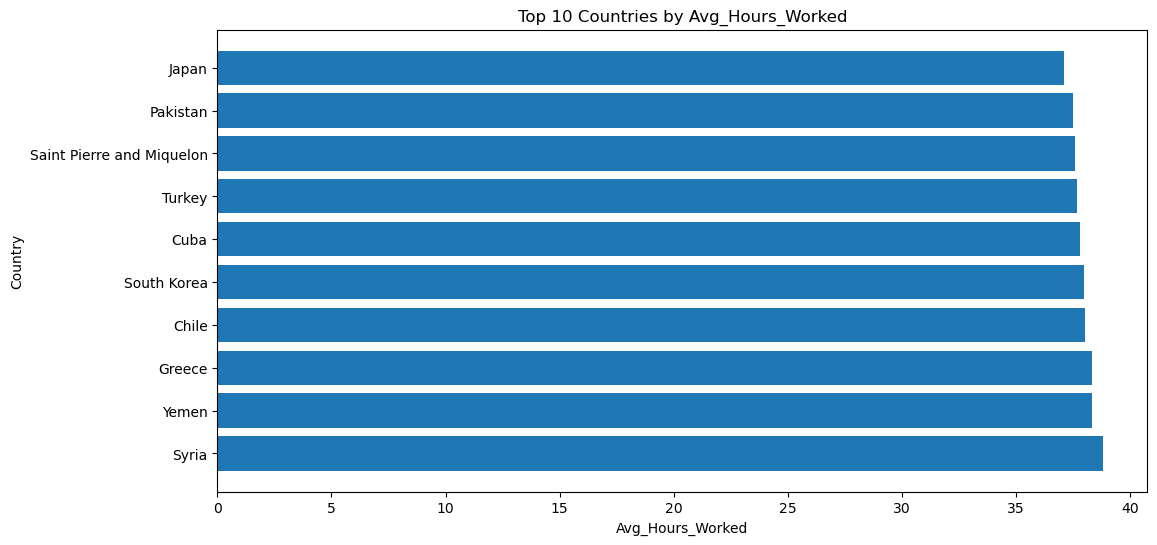

In [20]:
# Get the top 10 countries by Average Hours Worked  
top_countries = imputed_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Avg_Hours_Worked'])
plt.title("Top 10 Countries by Avg_Hours_Worked")
plt.xlabel("Avg_Hours_Worked")
plt.ylabel("Country")
plt.show()

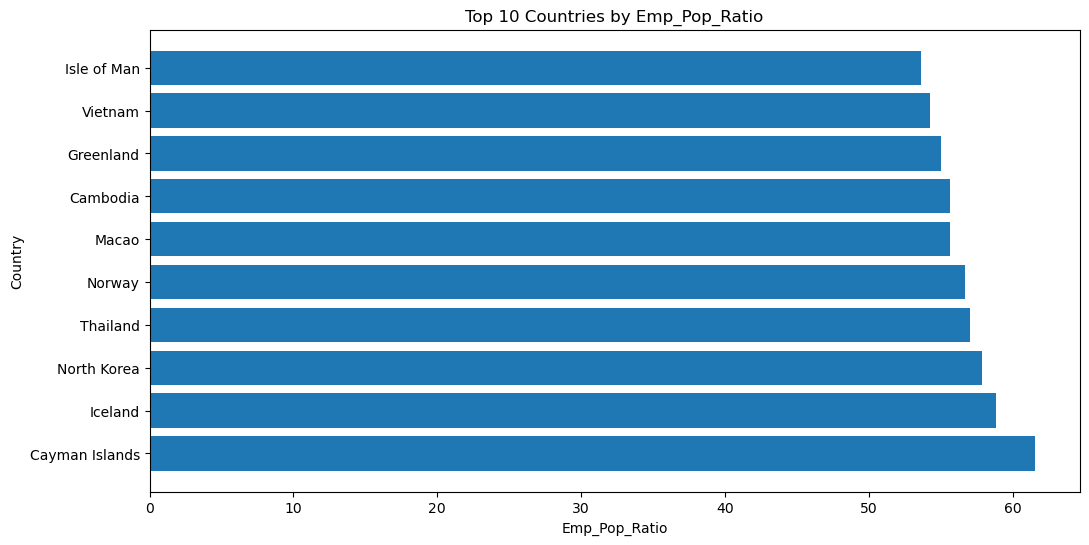

In [21]:
# Get the top 10 countries by Emp_Pop_Ratio  
top_countries = imputed_df.groupby('Entity')['Emp_Pop_Ratio'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Emp_Pop_Ratio')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Emp_Pop_Ratio'])
plt.title("Top 10 Countries by Emp_Pop_Ratio")
plt.xlabel("Emp_Pop_Ratio")
plt.ylabel("Country")
plt.show()

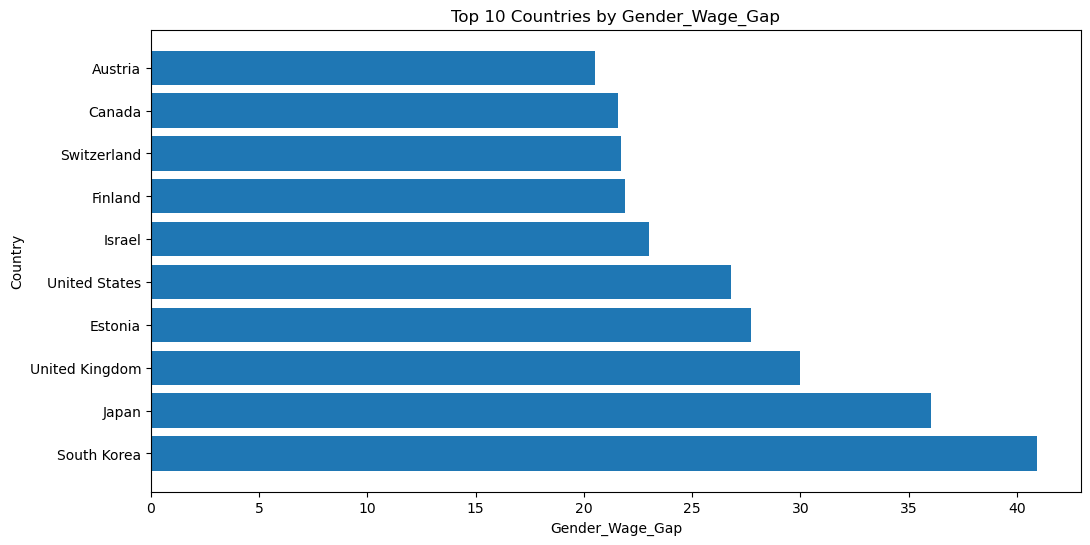

In [22]:
# Get the top 10 countries by Gender_Wage_Gap
top_countries = merged_df.groupby('Entity')['Gender_Wage_Gap'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Gender_Wage_Gap')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Gender_Wage_Gap'])
plt.title("Top 10 Countries by Gender_Wage_Gap")
plt.xlabel("Gender_Wage_Gap")
plt.ylabel("Country")
plt.show()

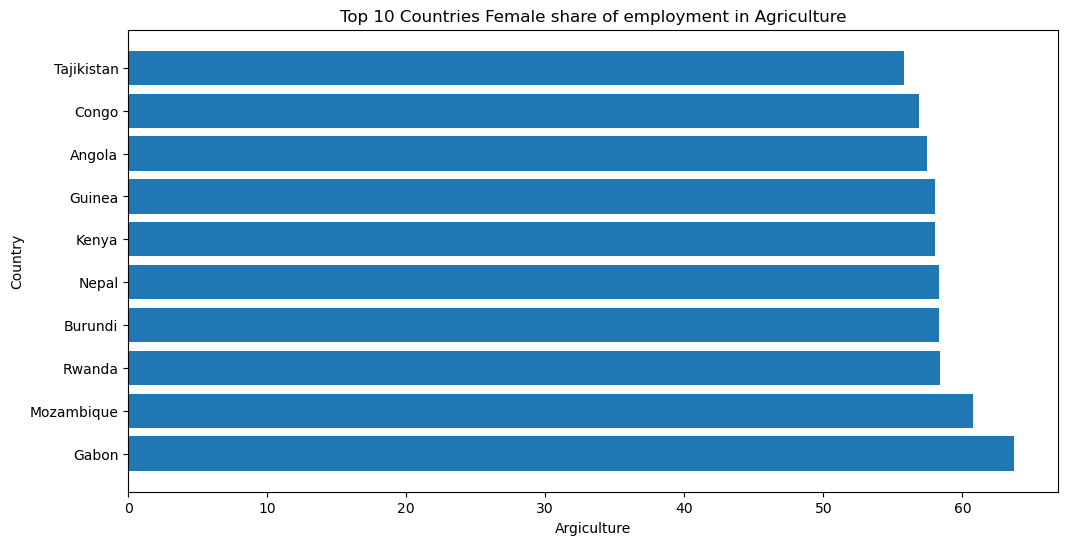

In [23]:
# Get the top 10 countries by Argiculture
top_countries = merged_df.groupby('Entity')['Argiculture'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Argiculture')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Argiculture'])
plt.title("Top 10 Countries Female share of employment in Agriculture")
plt.xlabel("Argiculture")
plt.ylabel("Country")
plt.show()

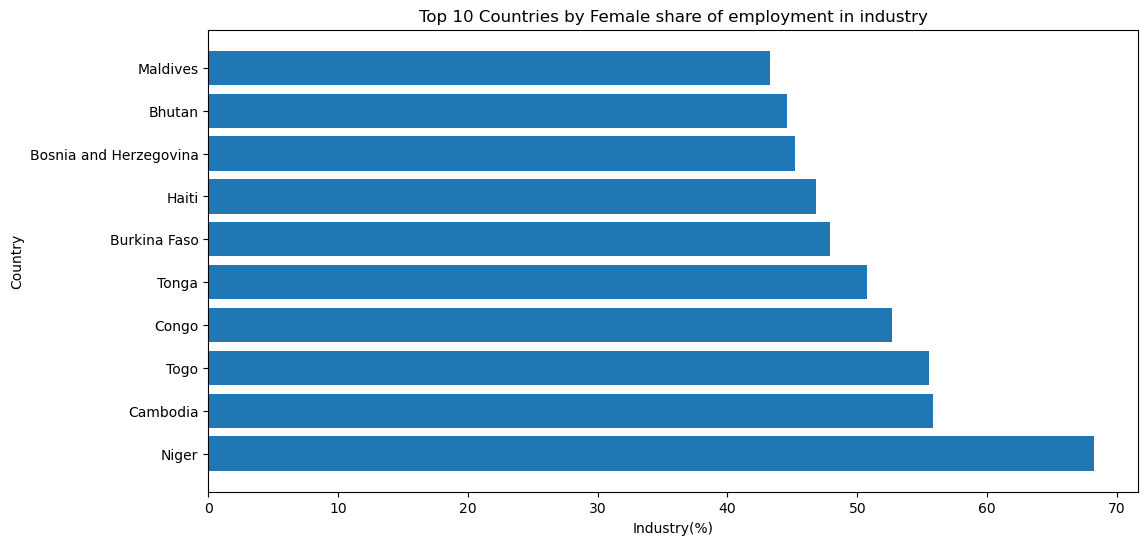

In [24]:
# Get the top 10 countries by Industry
top_countries = merged_df.groupby('Entity')['Industry'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Industry')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Industry'])
plt.title("Top 10 Countries by Female share of employment in industry")
plt.xlabel("Industry(%)")
plt.ylabel("Country")
plt.show()

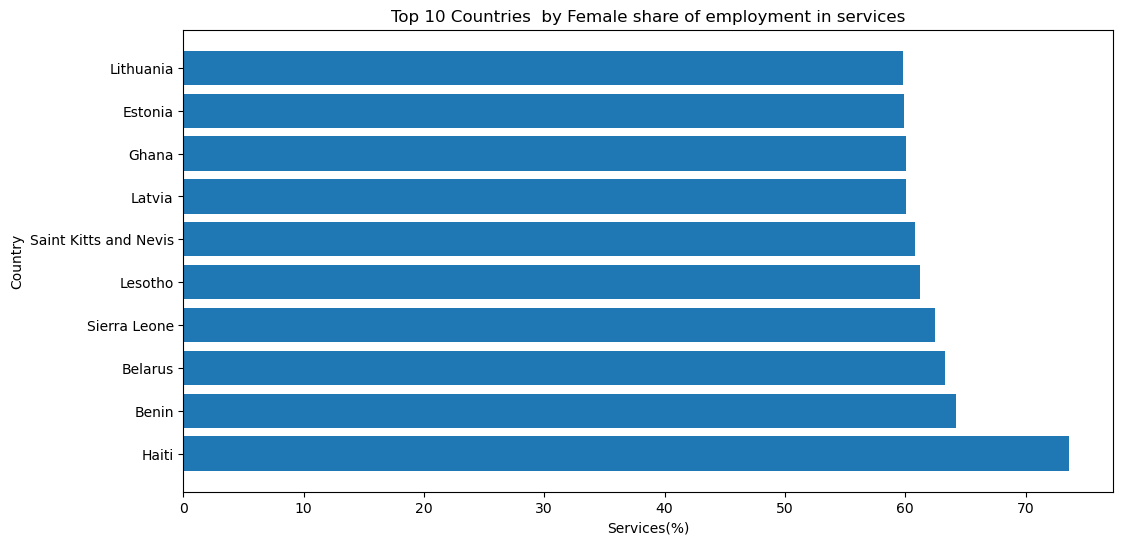

In [25]:
# Get the top 10 countries by Services
top_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Services'])
plt.title("Top 10 Countries  by Female share of employment in services")
plt.xlabel("Services(%)")
plt.ylabel("Country")
plt.show()

BASIC EDA: Bottom 10 Countries for each of the features

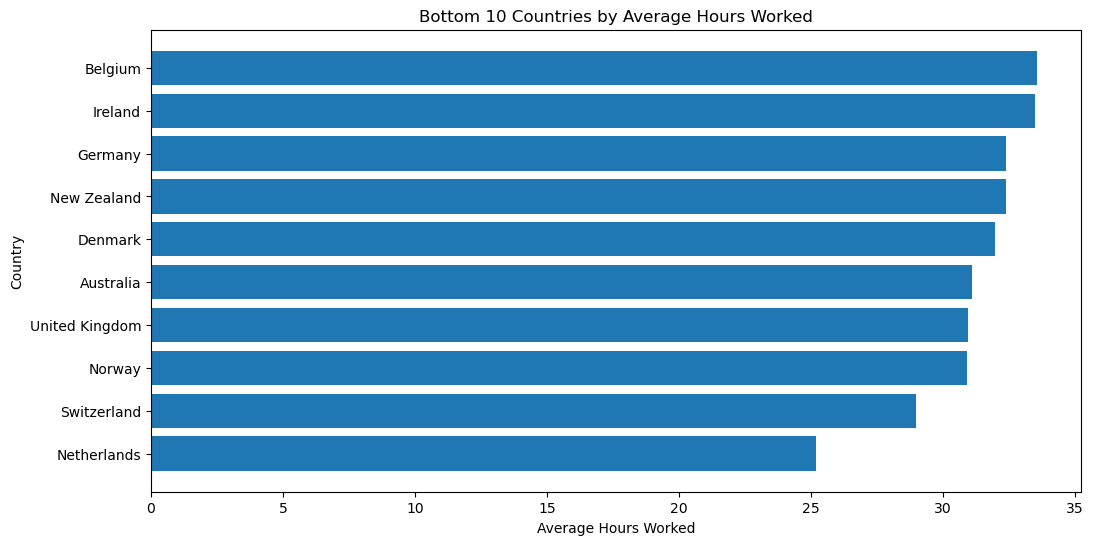

In [26]:

# Get the bottom 10 countries by average hours worked
bottom_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Avg_Hours_Worked'])
plt.title("Bottom 10 Countries by Average Hours Worked")
plt.xlabel("Average Hours Worked")
plt.ylabel("Country")
plt.show()

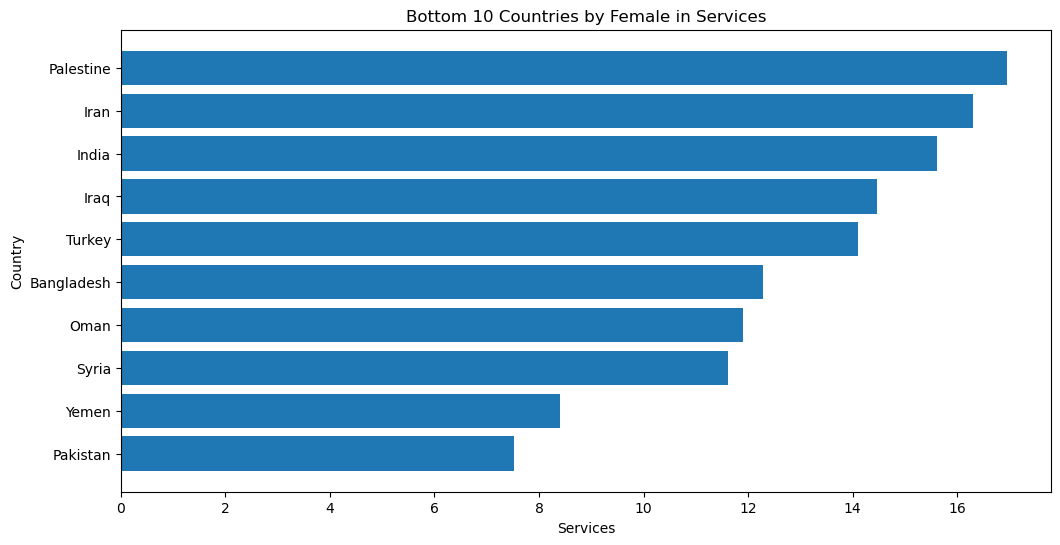

In [27]:
# Get the top 10 countries by Services
bottom_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Services'])
plt.title("Bottom 10 Countries by Female in Services")
plt.xlabel("Services")
plt.ylabel("Country")
plt.show()

CREATE A PROFESSIONAL WELLBEING SCORE 0-1

In [28]:
# Define the columns that will be used to create the professional wellbeing score
columns_to_use = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

# Scale the columns using Min-Max Scaler to have values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

# Calculate the professional wellbeing score as the average of the scaled columns
imputed_df['Professional_Wellbeing_Score'] = imputed_df[columns_to_use].mean(axis=1)

Scale the columns

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

Split the data into training and testing sets

In [30]:
from sklearn.model_selection import train_test_split

X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Development #1 
RandomForestRegressor

In [31]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score,make_scorer

# Define the features and target
X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
rf = RandomForestRegressor()

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(1, 20, 2)),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': [1.0, 'sqrt', 'log2']
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Display the best parameters found
print("Best parameters found: ", random_search.best_params_)

# Predict using the best model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculate and display the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2_best = r2_score(y_test, y_pred)

print("Random Forest Regressor:")
print("Mean Squared Error: ", mse)
print("R² Score: ", r2_best)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Random Forest Regressor:
Mean Squared Error:  6.278453795479315e-05
R² Score:  0.9883261795880963


Model Development #2
LightGBM Regressor (LGBMRegressor)

In [32]:
imputed_df.columns

Index(['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap',
       'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)',
       'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry',
       'Services', 'Entity', 'Code', 'Professional_Wellbeing_Score'],
      dtype='object')

In [33]:
from lightgbm import LGBMRegressor
import pandas as pd

imputed_df_copy = imputed_df.copy()
# Clean column names in the DataFrame
imputed_df_copy.columns = imputed_df_copy.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)

# Corrected list of columns to use (based on the cleaned column names)
corrected_columns_to_use = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                            'Labor_Force', 'GDP_per_capita__PPP__constant_2017_international___', 
                            'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                            'Services']

# Define the features and target
X = imputed_df_copy[corrected_columns_to_use]
y = imputed_df_copy['Professional_Wellbeing_Score']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LGBMRegressor:")
print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM R2 Score: {r2_lgb}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 8622, number of used features: 10
[LightGBM] [Info] Start training from score 0.435463
LGBMRegressor:
LightGBM MSE: 3.9479925593837536e-05
LightGBM R2 Score: 0.9926593142791044


Model #3 Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression:
MSE: 6.22747124967587e-32
R2: 1.0


Model #4 Gradient Boosting Regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

print("\nGradient Boosting Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2:", r2_score(y_test, y_pred_gb))


Gradient Boosting Regressor:
MSE: 6.958849219496495e-05
R2: 0.9870610888113232


In [36]:
#Hyperparameter Tuning Gradient Boosting Regressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

gb_model = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("MSE:", mse_best)
print("R2:", r2_best)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.11555555555555555}
MSE: 3.0609370876092964e-05
R2: 0.9943086576700437


Model #5 XGBoost Regressor

In [37]:
# Initialize the XGBRegressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))


XGBoost Regressor:
MSE: 4.445643726121712e-05
R2: 0.9917340083777603


In [38]:
# Hyperparameter Tuning for XGBoost Regressor

param_dist_xgb = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'min_child_weight': np.arange(1, 11)
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_params_xgb = random_search_xgb.best_params_
best_model_xgb = random_search_xgb.best_estimator_

y_pred_best_xgb = best_model_xgb.predict(X_test)

mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("\nXGBoost Regressor Best Parameters:", best_params_xgb)
print("MSE:", mse_best_xgb)
print("R2:", r2_best_xgb)


XGBoost Regressor Best Parameters: {'subsample': 0.5, 'n_estimators': 250, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.09444444444444444, 'colsample_bytree': 0.7}
MSE: 2.2772498559815083e-05
R2: 0.9957658036966198


Results for Models used

In [39]:
from sklearn.metrics import mean_squared_error, r2_score


print("Random Forest Regressor:")
print("Mean Squared Error: ", mse)
print("R² Score: ", r2_best)


print("LGBMRegressor:")
print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM R2 Score: {r2_lgb}")


print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))


print("\nGradient Boosting Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2:", r2_score(y_test, y_pred_gb))

# After hyperparameter tuning 
print("Best Parameters:", best_params)
print("MSE:", mse_best)
print("R2:", r2_best)

print("\nXGBoost Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))

# After hyperparameter tuning 
print("\nXGBoost Regressor Best Parameters:", best_params_xgb)
print("MSE:", mse_best_xgb)
print("R2:", r2_best_xgb)

Random Forest Regressor:
Mean Squared Error:  6.278453795479315e-05
R² Score:  0.9943086576700437
LGBMRegressor:
LightGBM MSE: 3.9479925593837536e-05
LightGBM R2 Score: 0.9926593142791044
Linear Regression:
MSE: 6.22747124967587e-32
R2: 1.0

Gradient Boosting Regressor:
MSE: 6.958849219496495e-05
R2: 0.9870610888113232
Best Parameters: {'n_estimators': 250, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.11555555555555555}
MSE: 3.0609370876092964e-05
R2: 0.9943086576700437

XGBoost Regressor:
MSE: 4.445643726121712e-05
R2: 0.9917340083777603

XGBoost Regressor Best Parameters: {'subsample': 0.5, 'n_estimators': 250, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.09444444444444444, 'colsample_bytree': 0.7}
MSE: 2.2772498559815083e-05
R2: 0.9957658036966198


Model #6 Neural Networks with relu 

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Define the input features (X) and the target variable (y)
X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with a single neuron

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
270/270 - 2s - 6ms/step - loss: 0.0192
Epoch 2/50
270/270 - 0s - 1ms/step - loss: 0.0020
Epoch 3/50
270/270 - 0s - 1ms/step - loss: 0.0012
Epoch 4/50
270/270 - 0s - 2ms/step - loss: 8.2407e-04
Epoch 5/50
270/270 - 0s - 2ms/step - loss: 6.2399e-04
Epoch 6/50
270/270 - 0s - 1ms/step - loss: 5.0228e-04
Epoch 7/50
270/270 - 0s - 1ms/step - loss: 3.9707e-04
Epoch 8/50
270/270 - 0s - 2ms/step - loss: 3.3274e-04
Epoch 9/50
270/270 - 0s - 2ms/step - loss: 2.7186e-04
Epoch 10/50
270/270 - 0s - 2ms/step - loss: 2.2973e-04
Epoch 11/50
270/270 - 1s - 2ms/step - loss: 1.9260e-04
Epoch 12/50
270/270 - 1s - 2ms/step - loss: 1.6356e-04
Epoch 13/50
270/270 - 0s - 2ms/step - loss: 1.6302e-04
Epoch 14/50
270/270 - 1s - 2ms/step - loss: 1.4481e-04
Epoch 15/50
270/270 - 1s - 2ms/step - loss: 1.2612e-04
Epoch 16/50
270/270 - 1s - 2ms/step - loss: 1.1267e-04
Epoch 17/50
270/270 - 1s - 2ms/step - loss: 1.0658e-04
Epoch 18/50
270/270 - 1s - 2ms/step - loss: 8.6906e-05
Epoch 19/50
270/270 - 1s - 2ms/

In [41]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten y_pred and y_test to 1-dimensional arrays
y_pred = y_pred.flatten()
y_test = y_test.values.flatten()

# Evaluate the model using Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test) ** 2)
print("MSE:", mse)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 5.68870309221823e-06


In [42]:
imputed_df

,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services,Entity,Code,Professional_Wellbeing_Score
0,2001.0,-1.677828,0.629078,-1.457352,0.205657,1.395496,1.000042,-0.841500,0.729851,-0.363011,0.601578,Australia,AUS,0.415219
1,2002.0,-1.721687,0.660270,-1.371421,0.220525,1.458425,1.000042,-0.841500,0.560285,-0.380671,0.619340,Australia,AUS,0.415169
2,2003.0,-1.737097,0.726941,-1.616938,0.268952,1.502539,0.953422,-0.841500,0.467795,-0.353379,0.648520,Australia,AUS,0.411594
3,2004.0,-1.657903,0.729586,-1.445076,0.251991,1.575816,1.206088,-0.841500,0.701393,-0.481811,0.645983,Australia,AUS,0.423088
4,2005.0,-1.657135,0.856452,-1.273214,0.344804,1.622037,1.223755,-0.841500,0.560285,-0.457730,0.692925,Australia,AUS,0.428497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10773,2011.0,1.254749,1.184934,-2.476248,0.919203,-0.481321,0.795140,-0.841500,0.308900,1.439857,0.711956,Taiwan,TWN,0.435380
10774,2012.0,0.946162,0.507338,-2.677573,-0.092440,-0.266474,0.459677,-0.425364,0.159492,1.412565,0.747480,Taiwan,TWN,0.417662
10775,2013.0,0.728703,-0.107016,-2.746318,0.582840,-0.391236,-0.342824,0.406908,0.215224,1.422197,0.783004,Taiwan,TWN,0.440445
10776,2014.0,0.712154,0.869585,-2.500800,-0.361496,-0.396112,-0.059875,-0.009228,0.287556,1.394905,0.813453,Taiwan,TWN,0.427406


Build Gradio App

In [43]:
import gradio as gr

def get_professional_wellbeing_score(entity_name):
    # Search for the entity name in the dataset
    entity_row = imputed_df[imputed_df["Entity"] == entity_name]
    if entity_row.empty:
        print(f"Entity '{entity_name}' not found in dataset")
        return "Entity not found"
    else:
        # Return the professional wellbeing score for the entity
        print(f"Entity '{entity_name}' found in dataset")
        return entity_row["Professional_Wellbeing_Score"].values[0]

# Create the Gradio app
gr_interface = gr.Interface(
    fn=get_professional_wellbeing_score,
    inputs="text",
    outputs="text",
    title="Professional Wellbeing Score Lookup",
    description="Enter an entity name to get its professional wellbeing score"
)

Connect gradio app with OPENAI LLM to provide explaination and suggestion for each country's professional wellbeing score. 

In [44]:
import gradio as gr
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Load the API key from the environment variable
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if not openai_api_key:
    raise ValueError("OpenAI API key not found. Please set it in your .env file.")

headers = {
    'Authorization': f'Bearer {openai_api_key}',
    'Content-Type': 'application/json',
}

Defining the Explainations and Suggestions outputs

In [45]:
def generate_explanations(entity_name):
    entity_row = imputed_df[imputed_df["Entity"] == entity_name]
    
    # Calculate the average values of the features across all entities, excluding 'Year'
    average_values = imputed_df.select_dtypes(include=['number']).drop('Year', axis=1).mean()
 
    
    # Identify the features that are higher or lower for the entity compared to the average
    explanations = []
    for feature in entity_row.columns:
        if feature != "Entity" and feature != "Professional_Wellbeing_Score" and feature != 'Year' and entity_row[feature].dtype.kind in 'bifc':
            if entity_row[feature].values[0] > average_values[feature]:
                explanations.append(f"The entity has a higher value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
            elif entity_row[feature].values[0] < average_values[feature]:
                explanations.append(f"The entity has a lower value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
    
    # Define the professional score as high or low on a scale of 0-1
    wellbeing_score = entity_row["Professional_Wellbeing_Score"].values[0]
    if wellbeing_score >= 0.5:
        wellbeing_score_label = "high"
    else:
        wellbeing_score_label = "low"
    
    # Generate a paragraph explaining the professional wellbeing score
    explanation_paragraph = f"The entity {entity_name} has a professional wellbeing score of {wellbeing_score:.2f}, which is considered {wellbeing_score_label}. "
    explanation_paragraph += "The following factors contribute to this score: "
    explanation_paragraph += ", ".join(explanations)
    
    return explanation_paragraph

def generate_suggestions(entity_name):
    wellbeing_score = get_professional_wellbeing_score(entity_name)
    explanations = generate_explanations(entity_name)
    
    # Create a prompt for the LLM model
    prompt = f"Generate suggestions to improve professional wellbeing of women in {entity_name} based on the following explanations: {', '.join(explanations)}"
    
    data = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 1024
    }

    try:
        response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, json=data)
        response.raise_for_status()
        result = response.json()
        suggestions = result['choices'][0]['message']['content'].strip()
        return suggestions
    except requests.exceptions.HTTPError as err:
        return f"HTTP error occurred: {err}"
    except Exception as e:
        return f"An error occurred: {e}"

In [46]:
# Create and Launch Gradio Interface
gr_interface = gr.Interface(
    fn=lambda entity_name: (
        get_professional_wellbeing_score(entity_name),
        generate_explanations(entity_name),
        generate_suggestions(entity_name)
    ),
    inputs=[
        gr.Textbox(label="Entity Name"),
    ],
    outputs=[
        gr.Textbox(label="Professional Wellbeing Score"),
        gr.Textbox(label="Explanations"),
        gr.Textbox(label="Suggestions")
    ],
    title="Professional Wellbeing Score Lookup and Suggestions",
    description="Enter an entity name or speak the name to get its professional wellbeing score, explanations, and suggestions for improvement"
)
# Launch the Gradio app
gr_interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://9e69e05ce3cc8a5ef5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Top 10 Unique Entities with Highest Professional Wellbeing Scores

Top 10 unique entities with the highest professional wellbeing scores:
          Entity  Professional_Wellbeing_Score
3624     Vietnam                      0.669681
1323    Cameroon                      0.656106
5269  Kazakhstan                      0.649253
2573       Niger                      0.640200
753     Slovenia                      0.639434
1046  Azerbaijan                      0.639434
1428       Congo                      0.637377
1747     Georgia                      0.636732
2302  Madagascar                      0.632285
729      Romania                      0.631117


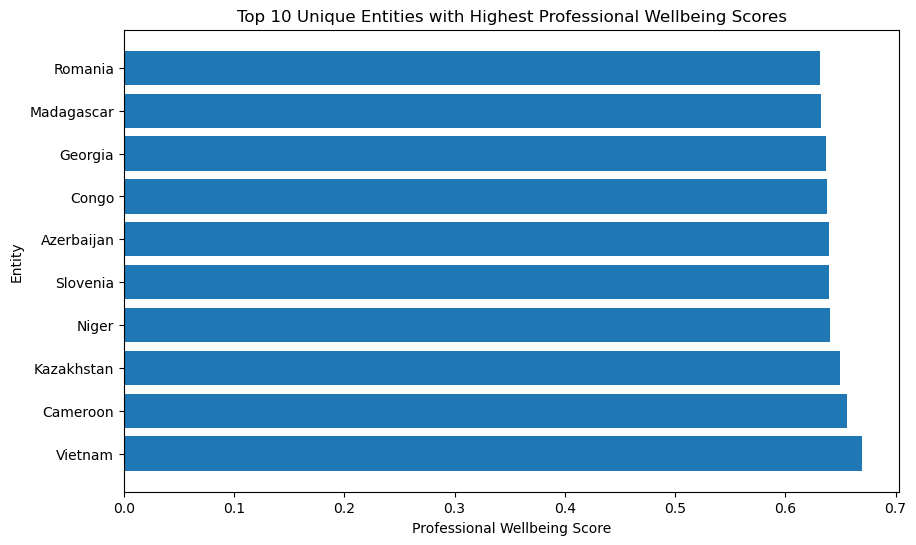

In [47]:
import matplotlib.pyplot as plt

# Get the unique entities with the highest professional wellbeing scores
unique_entities = imputed_df.sort_values('Professional_Wellbeing_Score', ascending=False).drop_duplicates('Entity')[['Entity', 'Professional_Wellbeing_Score']].head(10)

print("Top 10 unique entities with the highest professional wellbeing scores:")
print(unique_entities)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the unique entities
ax.barh(unique_entities['Entity'], unique_entities['Professional_Wellbeing_Score'])

# Set title and labels
ax.set_title('Top 10 Unique Entities with Highest Professional Wellbeing Scores')
ax.set_xlabel('Professional Wellbeing Score')
ax.set_ylabel('Entity')

# Show the plot
plt.show()

Top 10 unique entities with the lowest professional wellbeing scores

Top 10 unique entities with the lowest professional wellbeing scores:
             Entity  Professional_Wellbeing_Score
1588          Egypt                      0.184196
1071        Bahrain                      0.197284
2641       Pakistan                      0.202132
2999   Saudi Arabia                      0.209824
10369         Syria                      0.211607
1095     Bangladesh                      0.223750
2194         Kuwait                      0.230665
2162         Jordan                      0.233423
10512        Turkey                      0.236847
6087           Oman                      0.255147


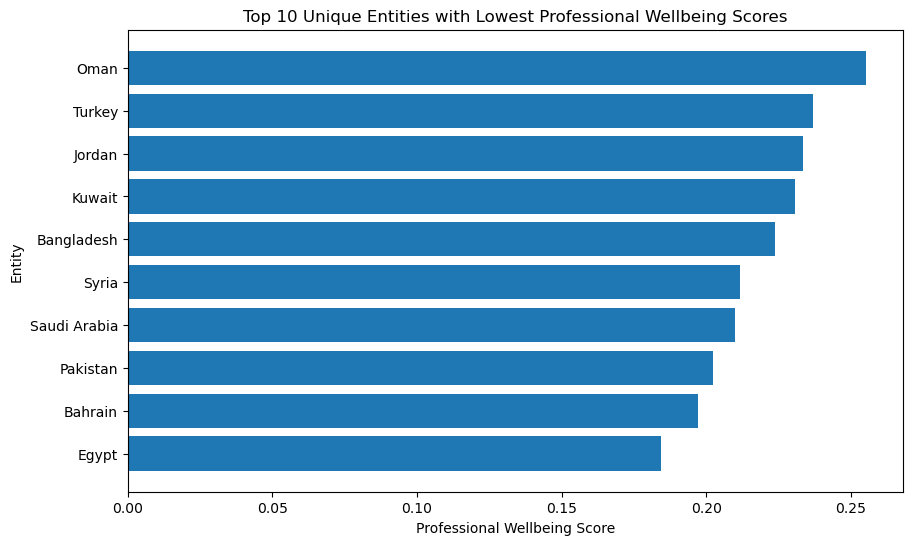

In [49]:
# Get the unique entities with the lowest professional wellbeing scores
unique_entities = imputed_df.sort_values('Professional_Wellbeing_Score').drop_duplicates('Entity')[['Entity', 'Professional_Wellbeing_Score']].head(10)

print("Top 10 unique entities with the lowest professional wellbeing scores:")
print(unique_entities)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the unique entities
ax.barh(unique_entities['Entity'], unique_entities['Professional_Wellbeing_Score'])

# Set title and labels
ax.set_title('Top 10 Unique Entities with Lowest Professional Wellbeing Scores')
ax.set_xlabel('Professional Wellbeing Score')
ax.set_ylabel('Entity')

# Show the plot
plt.show()

Tried connecting with OPENAI WHISPER

In [50]:
# import openai
# import gradio as gr
# import os
# import requests
# from dotenv import load_dotenv
# import pandas as pd
# import numpy as np
# from requests.adapters import HTTPAdapter
# from requests.packages.urllib3.util.retry import Retry
# # Load the API key from the environment variable
# load_dotenv()
# openai_api_key = os.getenv('OPENAI_API_KEY')
# if not openai_api_key:
#     raise ValueError("OpenAI API key not found. Please set it in your .env file.")
# openai.api_key = openai_api_key
# # Setup requests session with retries
# session = requests.Session()
# retry = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
# adapter = HTTPAdapter(max_retries=retry)
# session.mount('http://', adapter)
# session.mount('https://', adapter)
# # Add function to convert speech to text with retries
# def transcribe_audio_to_text(audio):
#     try:
#         with open(audio, "rb") as audio_file:
#             transcript = openai.Audio.transcriptions.create(
#                 audio_file=audio_file, model="whisper-1", timeout=180
#             )
#         return transcript["text"]
#     except Exception as e:
#         return str(e)
# # Define existing functions
# def get_professional_wellbeing_score(entity_name):
#     # Convert entity_name to title case for case insensitivity
#     entity_name = entity_name.title()
#     # Search for the entity name in the dataset
#     entity_row = imputed_df[imputed_df["Entity"] == entity_name]
#     if entity_row.empty:
#         return "Entity not found"
#     else:
#         # Return the professional wellbeing score for the entity
#         return entity_row["Professional_Wellbeing_Score"].values[0]
# def generate_explanations(entity_name):
#     # Convert entity_name to title case for case insensitivity
#     entity_name = entity_name.title()
#     entity_row = imputed_df[imputed_df["Entity"] == entity_name]
#     if entity_row.empty:
#         return "Entity not found"
#     # Calculate the average values of the features across all entities, excluding 'Year'
#     average_values = imputed_df.select_dtypes(include=['number']).drop('Year', axis=1).mean()
#     # Identify the features that are higher or lower for the entity compared to the average
#     explanations = []
#     for feature in entity_row.columns:
#         if feature != "Entity" and feature != "Professional_Wellbeing_Score" and feature != 'Year' and entity_row[feature].dtype.kind in 'bifc':
#             if entity_row[feature].values[0] > average_values[feature]:
#                 explanations.append(f"The entity has a higher value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
#             elif entity_row[feature].values[0] < average_values[feature]:
#                 explanations.append(f"The entity has a lower value for {feature} compared to the average, which is associated with higher professional wellbeing scores.")
#     # Define the professional score as high or low on a scale of 0-1
#     wellbeing_score = entity_row["Professional_Wellbeing_Score"].values[0]
#     if wellbeing_score >= 0.5:
#         wellbeing_score_label = "high"
#     else:
#         wellbeing_score_label = "low"
#     # Generate a paragraph explaining the professional wellbeing score
#     explanation_paragraph = f"The entity {entity_name} has a professional wellbeing score of {wellbeing_score:.2f}, which is considered {wellbeing_score_label}. "
#     explanation_paragraph += "The following factors contribute to this score: "
#     explanation_paragraph += ", ".join(explanations)
#     return explanation_paragraph
# def generate_suggestions(entity_name):
#     # Convert entity_name to title case for case insensitivity
#     entity_name = entity_name.title()
#     explanations = generate_explanations(entity_name)
#     if explanations == "Entity not found":
#         return explanations
#     # Create a prompt for the LLM model
#     prompt = f"Generate suggestions to improve professional wellbeing of women in {entity_name} based on the following explanations: {explanations}"
#     data = {
#         "model": "gpt-3.5-turbo",
#         "messages": [
#             {"role": "system", "content": "You are a helpful assistant."},
#             {"role": "user", "content": prompt}
#         ],
#         "max_tokens": 1024
#     }
#     headers = {
#         'Authorization': f'Bearer {openai_api_key}',
#         'Content-Type': 'application/json',
#     }
#     try:
#         response = session.post('https://api.openai.com/v1/chat/completions', headers=headers, json=data, timeout=180)
#         response.raise_for_status()
#         result = response.json()
#         suggestions = result['choices'][0]['message']['content'].strip()
#         return suggestions
#     except requests.exceptions.HTTPError as err:
#         return f"HTTP error occurred: {err}"
#     except Exception as e:
#         return f"An error occurred: {e}"
# # Combine text and audio input functionality
# def handle_input(input_text, audio_file):
#     if audio_file:
#         entity_name = transcribe_audio_to_text(audio_file).title()
#     else:
#         entity_name = input_text.title()
#     score = get_professional_wellbeing_score(entity_name)
#     explanations = generate_explanations(entity_name)
#     suggestions = generate_suggestions(entity_name)
#     return score, explanations, suggestions
# # Create and Launch Gradio Interface
# gr_interface = gr.Interface(
#     fn=handle_input,
#     inputs=[
#         gr.Textbox(label="Entity Name"),
#         gr.Audio(type="filepath")
#     ],
#     outputs=[
#         gr.Textbox(label="Professional Wellbeing Score"),
#         gr.Textbox(label="Explanations"),
#         gr.Textbox(label="Suggestions")
#     ],
#     title="Professional Wellbeing Score Lookup and Suggestions",
#     description="Enter an entity name or speak the name to get its professional wellbeing score, explanations, and suggestions for improvement"
# )
# # Launch the Gradio app
# gr_interface.launch(share=True)